In [1]:
from pathlib import Path
import os
import shutil
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution, basinhopping
from pandas import Series, DataFrame
import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel

In [2]:
B_HIGH_LIMIT = 1.3

B_MAX = 1.2
FIELD_FRACTION = 0.35

B_REM = 1.4

TESLAMAX_PATH = Path.home() / "code" / "TeslaMax"

TESLAMAX_MPH_DIR = TESLAMAX_PATH / "java"

TESLAMAX_FILENAME = "TeslaMax_Model"
TESLAMAX_FILE_EXT = "mph"

TESLAMAX_FILE_STR = str(TESLAMAX_MPH_DIR / (TESLAMAX_FILENAME + "." + TESLAMAX_FILE_EXT))

PLAYGROUND_DIR = "teslamax-play"

In [3]:
TESLAMAX_FILE_STR

'C:\\Users\\fabiofortkamp\\code\\TeslaMax\\java\\TeslaMax_Model.mph'

In [4]:
os.chdir(TESLAMAX_PATH)

In [5]:
os.getcwd()

'C:\\Users\\fabiofortkamp\\code\\TeslaMax'

## Optimization using Scipy

In [6]:
def optimize_ramp(B_high,field_fraction,params,filename=None):
    """
    Run the TeslaMax optimization procedure, trying to match the profile
    to a ramp profile between 0 and 'B_high' with 'field_fraction', using the
    parameters in the dictionary 'params'.
    
    Return a TeslaMaxModel object, representing the optimized magnet,
    and the value of the cost function. The TeslaMaxModel object is already populated with simulation results.
    
    The simulation results are stored in directories inside PLAYGROUND_DIR.
    The COMSOL model file is saved as 'filename' (with '.mph' extension) in TESLAMAX_MPH_DIR, 
    if provided.
    """
    
    tmpd = TeslaMaxPreDesign(params)
    
    target_function = teslamax.calculate_ramp_profile
    
    B_low = 0.0
    
    target_args = (B_high,B_low,field_fraction)

    alpha_B_rem_g = tmpd.get_optimal_remanence_angles(target_function,target_args)
    cost_function = tmpd.calculate_functional_target(alpha_B_rem_g,
                                                    target_function,
                                                    target_args)
    
    tstamp = datetime.now().strftime("%Y%m%d%H%M%S")
    
    teslamax_playground = str(TESLAMAX_PATH / PLAYGROUND_DIR / tstamp  )
    
    tmm_g = TeslaMaxModel(tmpd,
                          alpha_B_rem_g,
                          path=teslamax_playground)
    tmm_g.run()
    
    if filename:
        shutil.copy(src=TESLAMAX_FILE_STR,
                    dst=str(TESLAMAX_MPH_DIR / (filename + "." + TESLAMAX_FILE_EXT)))
    
    return (tmm_g,cost_function)
    

In [7]:
import nemplot
from nemplot import nemplot_parameters

In [8]:
nemplot.set_dpi(600)
nemplot.set_figsize_cm(10)
nemplot.set_fontsize(12)
nemplot.set_latex_font("Times New Roman")

In [9]:
def refine_list(original_list, factor):
    """
    Return a new list, inserting more elements between the number in 'original_list'.
    
    Assumes 'original_list' is evenly-spaced. The spacing between each element is divided by 'factor'
    
    >>>refine_list([1,2,3],factor=2)
    [1.0,1.5,2.0,2.5,3.0]
    """
    
    # calculate the original spacing between elements and refine it
    d = original_list[1] - original_list[0]
    d_refined = d / factor
        
    max_value = max(original_list)
    min_value = min(original_list)
    
    # the number of elements is the number of divisions between the limit values, plus one aditional
    n_refined = ((max_value - min_value) / d_refined) + 1
        
    return np.linspace(min_value,max_value,int(n_refined))

In [10]:
def plot_optimized_ramp_comparison_angles(B_high,field_fraction,params,phi_S_values):
    """
    Plot a comparison between the magnetic profile from the TeslaMax simulations,
    and a ramp profile between 0 and 'B_high', with 'field_fraction', 
    for a situation without the internal magnet for the divisory angles in 'phi_S_values'. 
    
    Common parameters for the case with the magnet are read from 'params', 
    
    Save the figure with the appropriate naming inside the 'figures' directory.
    Save the corresponding COMSOL models.
    """
    
    p = params.copy()
    
    profile_fig_g, profile_axes_g = nemplot.create_plot(xlabel=r'$\phi [\si{\degree}]$',
                                                       ylabel=r'$B [\si{\tesla}]$')
    lw = 2.0
    
    results_list = []
    for phi_S in phi_S_values:
        
        p["phi_S_IV"] = phi_S
            
        tm_file_no_magnet = TESLAMAX_FILENAME + "_phi_S_%d" %(phi_S,)
        tmm_no_magnet, K_no_magnet = optimize_ramp(B_high,field_fraction,p,tm_file_no_magnet)
        
        results_list.append((tmm_no_magnet,K_no_magnet))
        phi_vector_no_magnet, B_vector_no_magnet = tmm_no_magnet.get_profile_data()
        
        label_str = r'$\phi\ped{S,IV} = \SI{' + "%d" %(phi_S,) + r'}{\degree}$'
        profile_axes_g.plot(phi_vector_no_magnet,B_vector_no_magnet,linewidth=lw,label=label_str)
    
    profile_axes_g.set_xlim(0,np.max(phi_vector_no_magnet))
    profile_axes_g.set_xticks(np.linspace(0,np.max(phi_vector_no_magnet),9))
    profile_axes_g.grid(True)
    profile_axes_g.set_ylim(0,B_HIGH_LIMIT)
    
    ticks = profile_axes_g.get_yticks()
    profile_axes_g.set_yticks(refine_list(ticks,4),minor=True)
    
    B_low = 0.0
    B_target_vector = teslamax.calculate_ramp_profile(phi_vector_no_magnet,B_high,B_low,field_fraction)
    profile_axes_g.plot(phi_vector_no_magnet,B_target_vector,'--',linewidth=lw,label="Target")
    
    profile_axes_g.legend(loc='upper left',bbox_to_anchor=(1.0,1.0))

    nemplot.save_figure(profile_fig_g,"profile_comparison_no_magnet_angles")
    
    return results_list

## Parameters for situation  without internal magnet

To understand these parameters, check the notebook `Choosing the profile and dimensions.ipynb`.

In [11]:
# Fixed parameters

FIXED_PARAMETERS_AMR = {
    "D_p[m]": 0.35e-3,
    "L[m]": 85e-3, 
    "W[m]": 30e-3,
    "H[m]": 19e-3,
    "N_r[]": 8, 
    "T_H[K]": 305.5,
    "dT[K]": 35,
    "Casing material": "Stainless steel",
    "t_casing[m]": 0.5e-3,
    "t_air[m]": 1e-3,
    "N_layers[]": 3,
    "T_C_layers[K]": np.array([273,283,290]),
    "Length_fraction_layers[%]": np.array([20,20,60]),
    "B_min[T]": 0.05}

FIXED_PARAMETERS_MAGNET = {"R_i": 0.015,
                "h_fc": 10e-3,
                "R_e": 0.3,
                "R_o": 40e-3,
                "R_s": 120e-3,
                "h_gap": (FIXED_PARAMETERS_AMR["H[m]"] + 2*(FIXED_PARAMETERS_AMR["t_casing[m]"] + FIXED_PARAMETERS_AMR["t_air[m]"])),
                "n_II": 0,
                "n_IV": 4,
                "phi_C_II": 0,
                "phi_S_II": 0,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

    
n_II = FIXED_PARAMETERS_MAGNET["n_II"]
n_IV = FIXED_PARAMETERS_MAGNET["n_IV"]
n = n_II + n_IV
        
# expand parameters to include remanence magnitudes for each segment
FIXED_PARAMETERS_MAGNET.update(teslamax.expand_parameters_from_remanence_array(B_REM*np.ones(n), 
                                                                    FIXED_PARAMETERS_MAGNET, 
                                                                    "B_rem"))

### Testing angles

***
For angle 45 °:
Value of K without magnet: 0.002852

Parameters:
{'R_i': 0.015, 'h_fc': 0.01, 'R_e': 0.3, 'R_o': 0.04, 'R_s': 0.12, 'h_gap': 0.022, 'n_II': 0, 'n_IV': 4, 'phi_C_II': 0, 'phi_S_II': 0, 'mu_r_II': 1.05, 'mu_r_IV': 1.05, 'linear_iron': 1, 'mu_r_iron': 5000.0, 'B_rem_IV_1': 1.3999999999999999, 'B_rem_IV_2': 1.3999999999999999, 'B_rem_IV_3': 1.3999999999999999, 'B_rem_IV_4': 1.3999999999999999, 'phi_S_IV': 45, 'R_g': 0.062, 'alpha_rem_IV_1': 0.0, 'alpha_rem_IV_2': 0.88191421499066247, 'alpha_rem_IV_3': 38.347338726943363, 'alpha_rem_IV_4': 96.867090207288143}
***
For angle 55 °:
Value of K without magnet: 0.006549

Parameters:
{'R_i': 0.015, 'h_fc': 0.01, 'R_e': 0.3, 'R_o': 0.04, 'R_s': 0.12, 'h_gap': 0.022, 'n_II': 0, 'n_IV': 4, 'phi_C_II': 0, 'phi_S_II': 0, 'mu_r_II': 1.05, 'mu_r_IV': 1.05, 'linear_iron': 1, 'mu_r_iron': 5000.0, 'B_rem_IV_1': 1.3999999999999999, 'B_rem_IV_2': 1.3999999999999999, 'B_rem_IV_3': 1.3999999999999999, 'B_rem_IV_4': 1.3999999999999999, 'phi_S

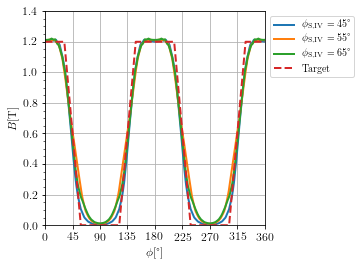

In [12]:
%matplotlib inline

phi_S_values = [45,55,65]

results_list = plot_optimized_ramp_comparison_angles(B_MAX,
                                                     FIELD_FRACTION,
                                                     FIXED_PARAMETERS_MAGNET,
                                                     phi_S_values)

for i in range(0,len(phi_S_values)):
    
    (tmm_no_magnet, K_no_magnet) = results_list[i]
    
    print("***")
    print("For angle %d °:" %(phi_S_values[i]))
    print("Value of K without magnet: %.6f" %(K_no_magnet))
    print()
    print("Parameters:")
    print(tmm_no_magnet.params)
    